In [1]:
import vamp
import librosa
import sys
sys.path.append("/usr/local/lib/python3.8/site-packages")
import essentia.standard as es
import numpy as np
import spleeter
import pydub

import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
from mido import MidiFile,MidiTrack
from midi2audio import FluidSynth
from collections import Counter
from scipy.stats.stats import pearsonr
import os
import numpy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.io import wavfile


# Seperate midi file into individual tracks and convert to wav 

In [2]:
def split_midi_tracks(midi_file,output_path):
        try:
            file=os.path.basename(midi_file)
            file_name = os.path.splitext(file)[0]
            mid = MidiFile(midi_file,clip=True)
            print(mid.type)
            path = output_path + str(file_name)
            os.mkdir(path) 
            original_channel = MidiFile()
            original_channel.ticks_per_beat=mid.ticks_per_beat
        
            channel_present = False
            channel_absent =False
            count =0 
            for i,track in enumerate(mid.tracks): 
                
                if len(track.name) == 0:
                    track.name = "piano track "+str(count)
                    count = count+1
                    print('Track {}: {}'.format(i, track.name))
                    
                    

                instrument_channel = MidiFile() # getting the current track
                instrument_channel.ticks_per_beat = mid.ticks_per_beat
        
                for msg in track:
                    if msg.is_meta ==False:
                        try:
                            if msg.channel >=0:
                                channel_absent = False
                                channel_present = True
                                break
                            else:
                                channel_present = False
                        except:
                            channel_present=False
                    else:
                        channel_present =False
                if channel_present ==True:
                    instrument_channel.tracks.append(track)
                    original_channel.tracks.append(track)
        
                    instrument_channel.save(output_path+'/'+str(file_name) +'/'+str(track.name)+ '.mid')
            original_channel.save(output_path+'/'+str(file_name) +'/'+ str(file_name)+ '.mid')
        
            return path,mid     
        except:
            print("Mid file does not contains track names or the channels are not in chronological order")

# Wav synthesizer

In [3]:
def wav_synthesizer(midi_files,output_path): 
    file=os.path.basename(midi_files)
    fs = FluidSynth('/Library/Audio/Sounds/Banks/FluidR3Mono_GM.sf3')
    file_name = os.path.splitext(file)[0]
    path = output_path+str(file_name)+'.wav'
    fs.midi_to_audio(midi_files,output_path+str(file_name)+'.wav')
    return path

    
    

# Melodia plugin

In [4]:
class Melodia:
    
    def melodia_plugin(self,audio_file):
        # This is how we load audio using Essentia
        loader = es.MonoLoader(filename=audio_file, downmix = 'mix', sampleRate = 44100)
        audio = loader()
        # This is how we load audio using Librosa
        audio, sr = librosa.load(audio_file, sr=44100, mono=True)
#         print(sr)
        data = vamp.collect(audio, sr, "mtg-melodia:melodia")
        # parameter values are specified by providing a dicionary to the optional "parameters" parameter:
        params = {"minfqr": 100.0, "maxfqr": 800.0, "voicing": 0.2, "minpeaksalience": 0.0}

        data = vamp.collect(audio, sr, "mtg-melodia:melodia", parameters=params)
        hop, melody = data['vector']
#         print(len(melody))
        timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)
        melody_pos = melody[:]
        melody_pos[melody<=0] = 0
        melody_data = []
#         self.plot_melody(timestamps,melody,audio_file)
        return timestamps,melody_pos,audio_file
    
    def plot_melody(self,timestamps,melody,audio_file):
        melody_pos = melody[:]
        melody_pos[melody<=0] = None
        plt.figure(figsize=(18,6))
        plt.plot(timestamps, melody_pos)
        plt.title(audio_file)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        return plt.show()

# Computes correlation initial

In [5]:
def plot_correlation(track_name,correlation,audio_file_name,max_track_names):
    dict_max = {}
    deleted=False
   
    for track,correlation in zip(track_name,correlation):
        dict_max[track] =correlation

    
#     standard_error = numpy.std(list(dict_max.values()), ddof=1) / numpy.sqrt(numpy.size(list(dict_max.values())))
        

#     dict_max = dict((k, v) for k, v in dict_max.items() if v >= 0)
    is_empty=bool(dict_max)

    if is_empty ==True:
        sorted_dict = dict(sorted(dict_max.items(), key=lambda x: x[1], reverse=True))
        
        for i in max_track_names:               
            if i not in sorted_dict:
                sorted_dict[i]=0
                print(max_track_names)



        max_tracks= list(sorted_dict.keys())
        max_corr = list(sorted_dict.values())
        fig = plt.figure(figsize=(10, 6))

        ax = fig.subplots()
        
#create chart
        ax.bar(x=max_tracks, #x-coordinates of bars
               height=max_corr, #height of bars
               color ='maroon',#error bar width
               capsize=4,align='center') #length of error bar caps
    

#         ax.set_yticks([-0.2,0,0.2,0.4,0.6,0.8, 1,1.2,1.4])

        ax.set_xlabel('Isolated instrument tracks')
        ax.set_ylabel("Correlation ")
        plt.show()
        
        
#     elif is_empty==True and len(dict_max) ==3:
#         sorted_dict = dict(sorted(dict_max.items(), key=lambda x: x[1], reverse=True))
#         for i in max_track_names:               
#             if i not in sorted_dict:
#                 sorted_dict[i]=0
#                 print(max_track_names)


#         max_tracks= list(sorted_dict.keys())
#         max_corr = list(sorted_dict.values())

#         fig = plt.figure(figsize=(10, 6))
#         ax = fig.subplots()


#         ax.bar(x=max_tracks, #x-coordinates of bars
#                height=max_corr, #height of bars
#                yerr=standard_error,
#                color ='maroon',#error bar width
#                capsize=4,align='center') #length of error bar caps
#         ax.set_yticks([-0.2,0,0.2,0.4,0.6,0.8, 1,1.2,1.4])
#         ax.set_xlabel('Isolated instrument tracks')
#         ax.set_ylabel("Correlation ")
# #         plt.show()
    

        

   
    
    


In [6]:
def max_track(track_name,correlation,audio_file_name):
#     print("max_track")
    dict_max = {}

    for track,correlation in zip(track_name,correlation):
        if correlation >0:
            dict_max[track] =correlation
    try:
        del dict_max[audio_file_name]
    except:
        pass
    dict_max = dict((k, v) for k, v in dict_max.items() if v >= 0)
    
    is_empty = bool(dict_max)
    if is_empty == True:
        max_track = max(dict_max, key=dict_max.get)
        max_corr = dict_max.get(max_track)
        return max_track
        
    
    
    
    

In [7]:
def remove_max_track(max_track,midi_file,audio_file_name,output_path,iteration):
    mid = midi_file
    path = output_path + str(audio_file_name)+'/'+'iteration'+str(iteration)
    os.mkdir(path) 
    original_channel = MidiFile()
    original_channel.ticks_per_beat=mid.ticks_per_beat

    channel_present = False
    channel_absent =False
    for i,track in enumerate(mid.tracks): 
        instrument_channel = MidiFile() # getting the current track
        instrument_channel.ticks_per_beat = mid.ticks_per_beat
        track_to_remove =""
        for m in max_track:
            if track.name == m:
                track_to_remove = track.name
                
        if track.name != track_to_remove:
            for msg in track:
                if msg.is_meta ==False:
                    try:
                        if msg.channel >=0:
                            channel_absent = False
                            channel_present = True
                            break
                        else:
                            channel_present = False
                    except:
                        channel_present=False
                else:
                    channel_present =False
            if channel_present ==True:
                original_channel.tracks.append(track)     
    original_channel.save(path+'/'+str(audio_file_name)+ '.mid')
    
    return path         


In [14]:
def identify_instrument_melody(melody_output,instrument_output):
    original_timestamps = melody_output[0][0]
    original_melody = melody_output[0][1]
    original_audio_file = melody_output[0][2]
    original_track_name = melody_output[0][3]
    
    fig = plt.figure(figsize=(10, 6))
    melody_pos_org = original_melody[:]
    melody_pos_org[original_melody<=0] = None
  
    ax = fig.subplots()
    colors = {'Piano right':'tab:blue','Piano left':'tab:red','Pedal':'tab:orange'}

    for track in instrument_output:
        track_dict = {}
        track_timestamps =track[0]
        track_melody = track[1]
        track_name = track[3]
        
        identical_timestamp=[]
        identical_melody = []
        
        melody_pos_track = track_melody[:]
        melody_pos_track[track_melody<=0] = None
        
        for org_timestamp,org_melody in zip(original_timestamps,melody_pos_org):
            for tr_timestamp,tr_melody in zip(track_timestamps,melody_pos_track):
                if tr_timestamp==org_timestamp:
                    if org_melody == tr_melody:
                        identical_timestamp.append(tr_timestamp)
                        identical_melody.append(tr_melody)
                        
#         for d,j in zip(sorted_tracks,sorted_corr):
        c = colors[track_name]  
        
        ax.scatter(track_timestamps,track_melody,label=track_name,color=c)

        ax.scatter(identical_timestamp,identical_melody,s=2.5,color='black',label='Melody',alpha=0.6)
        ax.set_xlabel("Time (s)",fontsize=25)
        ax.set_ylabel("Frequency (Hz)",fontsize=25)
        ax.set_yticks([0,100,200,300,400,500,600,700,800,900])
        ax.set_xticks([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
    

    box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 2, box.height])
            
            # Put a legend to the right of the current axis
#     ax.legend(loc='center left', borderpad=2,bbox_to_anchor=(1, 1),title='Tracks')
    plt.show()


In [10]:
def sliding_window(elements, window_size):
#     if len(elements) == window_size:
#         return elements
    for i in range(len(elements) - window_size + 1):
        return elements[i:i+window_size]

In [10]:
def instrument_across_melody(original_melody,instrument_tracks):
    org_timestamps = original_melody[0][0]
    org_melody = original_melody[0][1]
    org_audio_file = original_melody[0][2]
    org_track_name = original_melody[0][3]
    
    melody_pos_org = org_melody[:]
    melody_pos_org[org_melody<=0] = None
    
    window_size = 5
    fig = plt.figure(figsize=(18, 6))

    ax = fig.subplots()


    for i in range(len(org_timestamps)-window_size+1):
        org_melodies = melody_pos_org[i:i+window_size]
        org_times = org_timestamps[i:i+window_size]
        
        original_dict ={}
        if numpy.isnan(org_melodies).all()==False:
         
            for track in instrument_tracks:

                track_dict = {}
                track_timestamps =track[0]
                track_melody = track[1]
                track_name = track[3]


                melody_pos_track = track_melody[:]
                melody_pos_track[track_melody<=0] = None


                track_melodies = melody_pos_track[i:i+window_size]
                track_times=track_timestamps[i:i+window_size]
           
         
            for org_m,org_t in zip(org_melodies,org_times):
                for track_m,track_t in zip(track_melodies,track_times):
                    if org_t==track_t:
                        if org_m == track_m:
                            arr.append([track_name,track_t,track_m])  
            
            
        
    
    
    
  
    
    

In [11]:
def compute_correlation_timestamps(original_files_data,track_files_data):
    original_timestamps = original_files_data[0][0]
    original_melody = original_files_data[0][1]
    original_audio_name = original_files_data[0][3]
  
    original_dict ={}

    
    for timestamp,melody in zip(original_timestamps,original_melody):
        if melody >0:           
            original_dict[timestamp] = melody
    tracks =[]
    correlations=[]
    for track in track_files_data:
        track_dict ={}
        track_timestamps =track[0]
        track_melody = track[1]
        
        for timestamp,melody in zip(track_timestamps,track_melody):
            if melody >0:           
                track_dict[timestamp] = melody
                
        keys = list(original_dict.keys() & track_dict.keys())
        try:            
            corr, _ = pearsonr([original_dict.get(x, 0) for x in keys],[track_dict.get(x, 0) for x in keys])
            corr_round = numpy.round(corr,3)
            tracks.append(track[3])
            correlations.append(corr_round)
        except:
            pass
        
    
#     plot_correlation(tracks,correlations,original_audio_name)
    max_track_name = max_track(tracks,correlations,original_audio_name)
    return tracks,correlations,original_audio_name,max_track_name





# MAIN

In [12]:
def main():
    '''
    POP GENRE
    '''
    dataset_pop = '/Users/nissimolaji/Desktop/5thyear/Dissertation/Evaluation/dataset/Mel/'
    output_path_midi_pop = '/Users/nissimolaji/Desktop/5thyear/Dissertation/Evaluation/output_midi/Mel/'
    output_wav_file = '/Users/nissimolaji/Desktop/5thyear/Dissertation/Evaluation/output_wav/Mel/'
    
    output_iteration_midi_pop ='/Users/nissimolaji/Desktop/5thyear/Dissertation/Evaluation/output_midi/pop/'

    
    for file in os.listdir(dataset_pop):
        melodia = Melodia()
        original_melody_data=[]
        eval_out = []

        if not file.startswith('.'):
            original_file_name = os.path.splitext(file)[0]
            original_pop_file_name = dataset_pop+file
            
# Create directory to store each genre wav files
            pop_genre_wav_path = output_wav_file + str(original_file_name)+"/"
            os.mkdir(pop_genre_wav_path)       
            track_melody_data =[]


# Split the track into individual tracks and combine 
                        
            midi_files,file_in_midi = split_midi_tracks(original_pop_file_name,output_path_midi_pop)
     
            for m_file in os.listdir(midi_files):
                midi_file_name = midi_files+'/'+m_file
                track_file_name = os.path.splitext(m_file)[0]

           
                if str(m_file) == str(file):
                    original_wav = wav_synthesizer(midi_file_name,pop_genre_wav_path)
                    timestamps,melody,audio_file=melodia.melodia_plugin(original_wav)
                    original_melody_data.append([timestamps,melody,audio_file,track_file_name])
                else:
                    track_path=wav_synthesizer(midi_file_name,pop_genre_wav_path)
                    timestamps,melody,audio_file=melodia.melodia_plugin(track_path)

                    track_melody_data.append([timestamps,melody,audio_file,track_file_name])
                
            tracks,correlations,original_audio_name,max_track = compute_correlation_timestamps(original_melody_data,track_melody_data)
            identify_instrument_melody(original_melody_data,track_melody_data)
            plot_correlation(tracks,correlations,original_audio_name,[max_track])
            print("initial iteration")
            eval_out.append([tracks,correlations,original_audio_name,max_track])
    
    
#             Remove max track
            iteration = 0
            max_track_names=[]
            max_track_names.append(max_track)

            while iteration <=3:

                path_iteration = remove_max_track(max_track_names,file_in_midi,original_file_name,output_path_midi_pop,iteration)               
                data_without_max=[]
                track_data= track_melody_data
                
                for m in max_track_names:
                    for i,track in enumerate(track_data):
                        track_file = track[3]

                        if m == track_file:
                            track_data.pop(i)          
                   
                        
                for i in os.listdir(path_iteration):
                    if not i.startswith('.'):
                        removed_max_mid_file_name = os.path.splitext(i)[0]
                        removed_max_file = path_iteration+'/'+i
                        removed_max_wav_path = output_wav_file + str(original_file_name)+"/"+'iteration'+str(iteration)+'/'
                        os.mkdir(removed_max_wav_path)       
                        
                        wav_file = wav_synthesizer(removed_max_file,removed_max_wav_path)
                timestamps,melody,audio_file=melodia.melodia_plugin(wav_file)
                data_without_max.append([timestamps,melody,audio_file,removed_max_mid_file_name])
                tracks,correlations,original_audio_name,max_track = compute_correlation_timestamps(data_without_max,track_data)
#                 identify_instrument_melody(data_without_max,track_melody_data)

                max_track_names.append(str(max_track))
                eval_out.append([tracks,correlations,original_audio_name,max_track_names])
                print("iteration: "+str(iteration))
                print(max_track_names)
                plot_correlation(tracks,correlations,original_audio_name,max_track_names)

                
            # Create directory to store each genre wav files               
                
                iteration = iteration +1
    
        
        



1


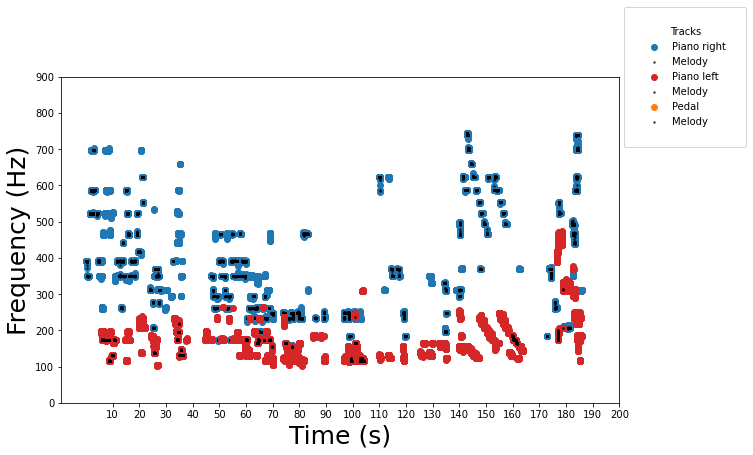

In [13]:
main()